In [1]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

In [2]:
# Only Training data is used

df_FaultFree = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_Faulty_Training.RData')['faulty_training']

In [3]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [6]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    # Iterate through the rows of the DataFrame in steps of size s
    for i in range(0, len(df)-w, s):
        # Extract a window of width w from the DataFrame, starting at row i
        x = np.array(df.iloc[i:i+w, 3:])
        # Extract the target value (faultNumber) for the last row of the window
        y = np.array(df.iloc[i+w-1, 0])
        # Append the window and target value to the X and Y lists, respectively
        X.append(x)
        Y.append(y)

    # Convert the X and Y lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [9]:
w = 20
s = 10

X = []
Y = []

# Loop through all faultNumbers except 3, 9, and 15, and all simulationRuns from 1 to 50
for j in [x for x in range(0,21) if x not in [9,15]]:
    for i in range(1, 50):
        # Select the rows from DataFrame DF with the current faultNumber and simulationRun, and remove highly correlated columns
        df = DF[(DF['faultNumber']==j) & (DF['simulationRun']==i) & (DF['sample']>20)]
        # Apply sliding window with window size w and step size s to the current DataFrame
        x_temp, y_temp = SlidingWindow(df, w, s)
        # Append the resulting windowed data and target values to the X and Y lists, respectively
        X.append(x_temp)
        Y.append(y_temp)
    
# Convert the X and Y lists to numpy arrays, and reshape them to the correct dimensions
X = np.array(X).reshape((-1, w, x_temp.shape[-1]))
Y = np.array(Y).reshape((-1,))

In [10]:
X.shape

(42826, 20, 52)

# Scale the dataset

In [7]:

# Initialize a StandardScaler object
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
reduced_data = DF[DF['faultNumber']==0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = reduced_data[(reduced_data['faultNumber'] == 0)].iloc[:, 3:]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)


StandardScaler()

In [11]:
# Apply the StandardScaler object `sc` to the input data X using the `transform()` method.
# The input data is first reshaped into a 2D array with shape (-1, X.shape[-1]) using the `reshape()` method.
# This flattens the data along the last dimension (i.e., the features).
# The `transform()` method then scales the data using the mean and standard deviation computed during training.
# The scaled data is returned as a 2D numpy array.
# Finally, the scaled data is reshaped back into its original shape (i.e., 3D tensor with shape X.shape)
# using the `reshape()` method.
X_sc = sc.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# OneHot Encoding of labels

In [12]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_enc = enc.transform(Y.reshape(-1, 1))

In [13]:
np.unique(Y)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., 10., 11., 12., 13.,
       14., 16., 17., 18., 19., 20.])

In [14]:
# Import train_test_split function from scikit-learn's model_selection module
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets using train_test_split
# X_sc is the input data that has been scaled using StandardScaler
# Y_enc is the target data that has been one-hot encoded
# test_size is set to 0.2, which means that 20% of the data will be used for testing, and the rest for training
# random_state is set to 42 for reproducibility of the results
x_train, x_test, y_train, y_test = train_test_split(X_sc, Y_enc, test_size=0.2, random_state=42)

In [15]:
y_train.shape

(34260, 19)

# Train the Neural Network algorithms

In [18]:

def LSTM_model(X_train,y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(128,activation="tanh",return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)

    # Define decoder layers
    decoded = Dense(300, activation='selu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile LSTM  model
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm_model

Epoch 1/200
134/134 [==============================] - 26s 157ms/step - loss: 0.6573 - accuracy: 0.7917 - val_loss: 0.2129 - val_accuracy: 0.9328
Epoch 2/200
134/134 [==============================] - 20s 151ms/step - loss: 0.1567 - accuracy: 0.9522 - val_loss: 0.1369 - val_accuracy: 0.9588
Epoch 3/200
134/134 [==============================] - 19s 141ms/step - loss: 0.1097 - accuracy: 0.9666 - val_loss: 0.1124 - val_accuracy: 0.9659
Epoch 4/200
134/134 [==============================] - 19s 143ms/step - loss: 0.0900 - accuracy: 0.9724 - val_loss: 0.1100 - val_accuracy: 0.9657
Epoch 5/200
134/134 [==============================] - 19s 142ms/step - loss: 0.0771 - accuracy: 0.9755 - val_loss: 0.1030 - val_accuracy: 0.9667
Epoch 6/200
134/134 [==============================] - 19s 143ms/step - loss: 0.0680 - accuracy: 0.9776 - val_loss: 0.1012 - val_accuracy: 0.9682
Epoch 7/200
134/134 [==============================] - 19s 143ms/step - loss: 0.0619 - accuracy: 0.9800 - val_loss: 0.0950 -

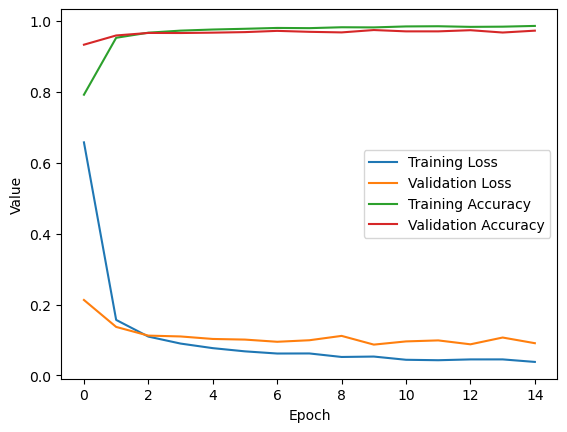

In [19]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = LSTM_model(x_train,y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(x_train, y_train, epochs=200, batch_size=256, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# Evaluate the trained model

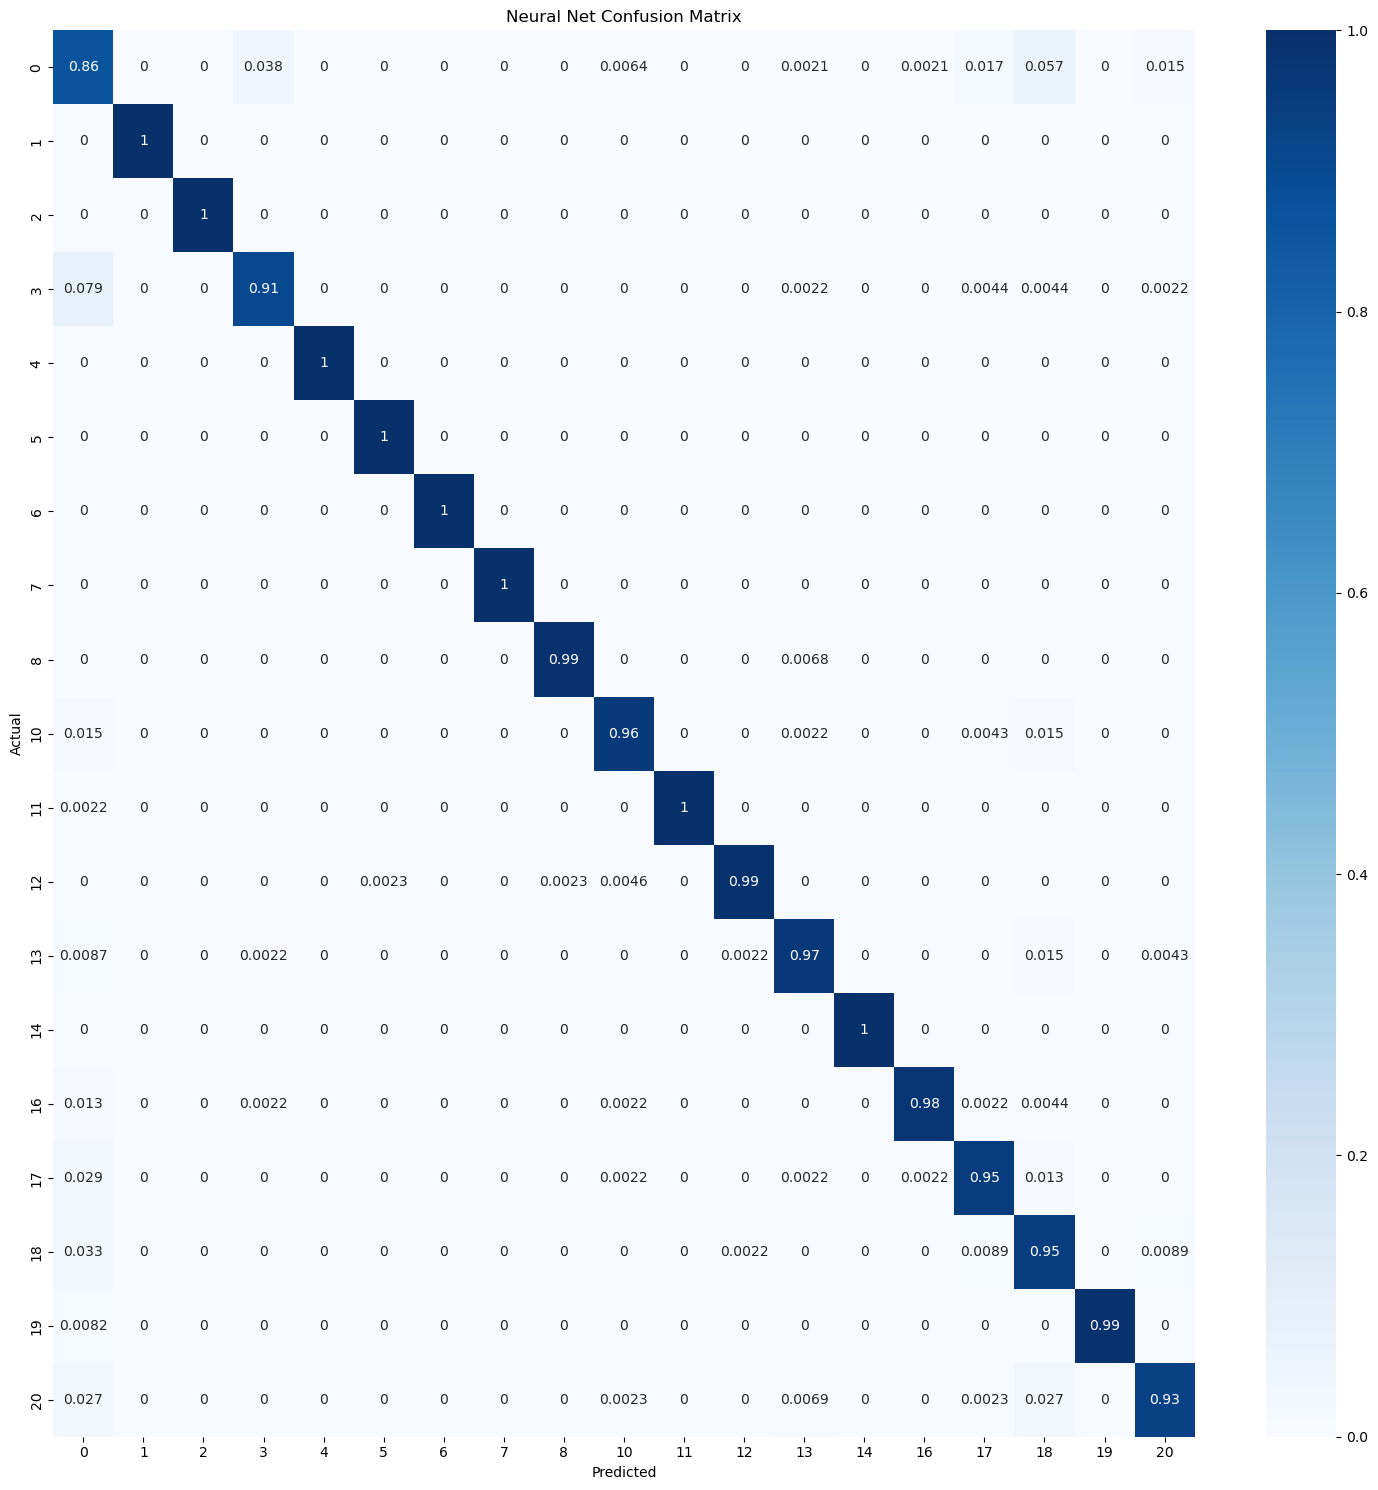

Neural Net accuracy_score: 0.9723324772355826


In [21]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels([str(x) for x in range(0,21) if x not in [9,15]])
    ax.set_yticklabels([str(x) for x in range(0,21) if x not in [9,15]])
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

y_pred = enc.inverse_transform(model.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'Neural Net Confusion Matrix')
print("Neural Net accuracy_score:", accuracy_score(y_true, y_pred))

# Realtime Fault Prediction

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


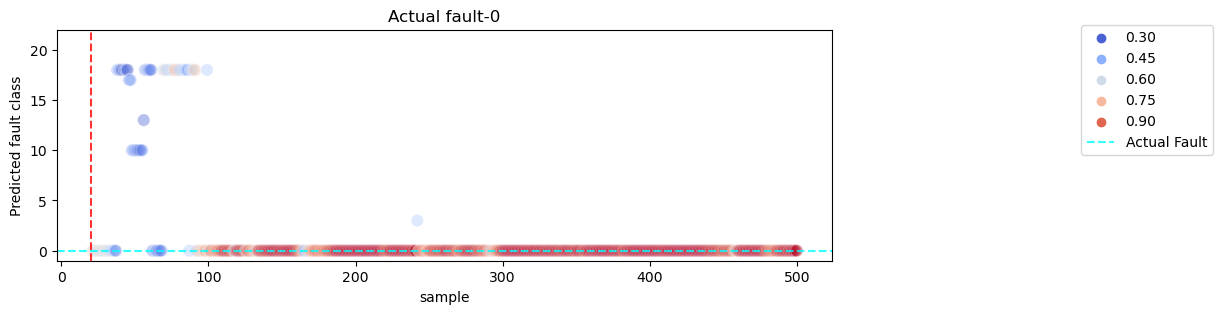

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


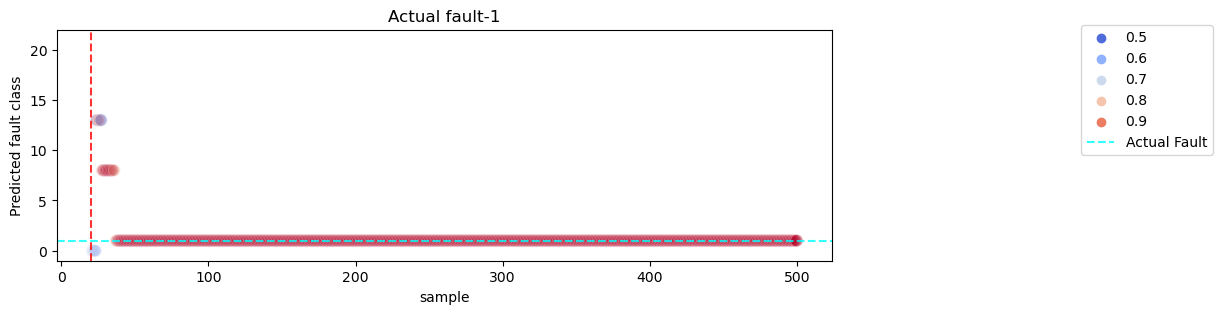

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


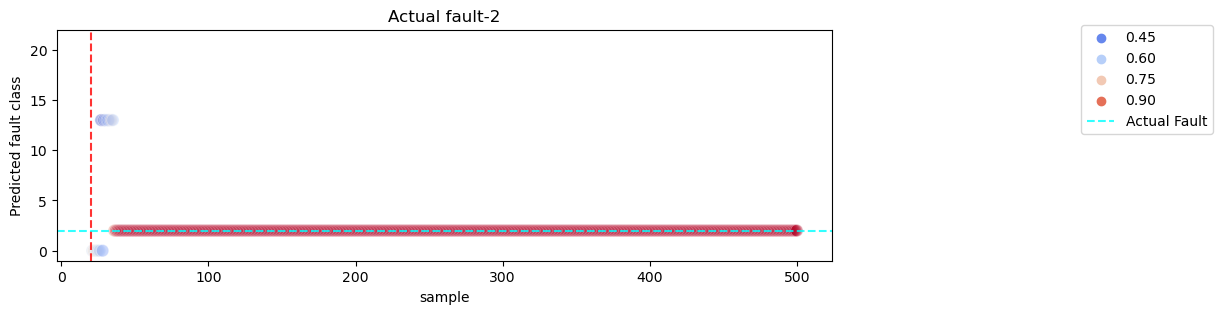

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


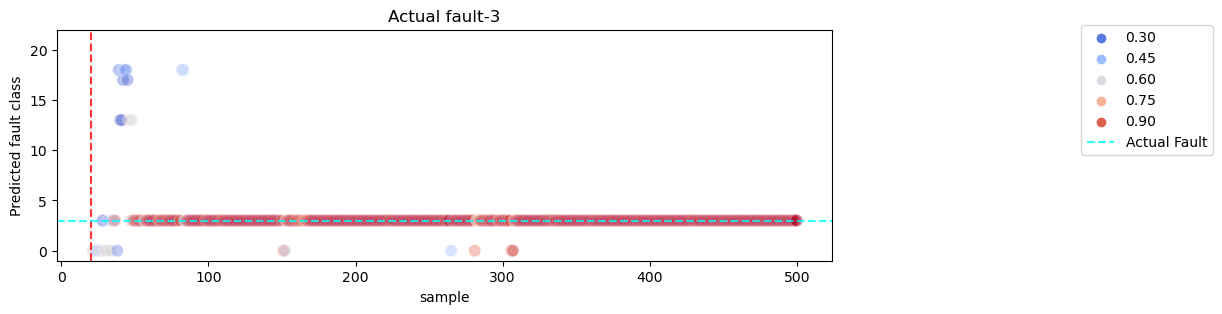

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


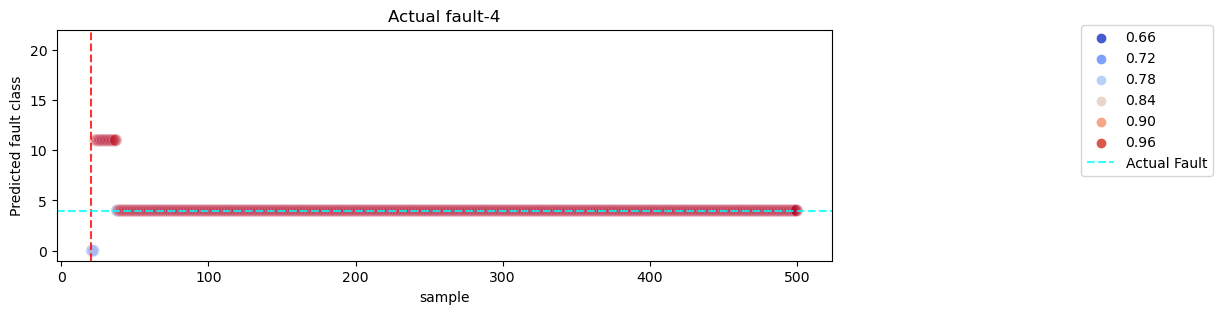

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


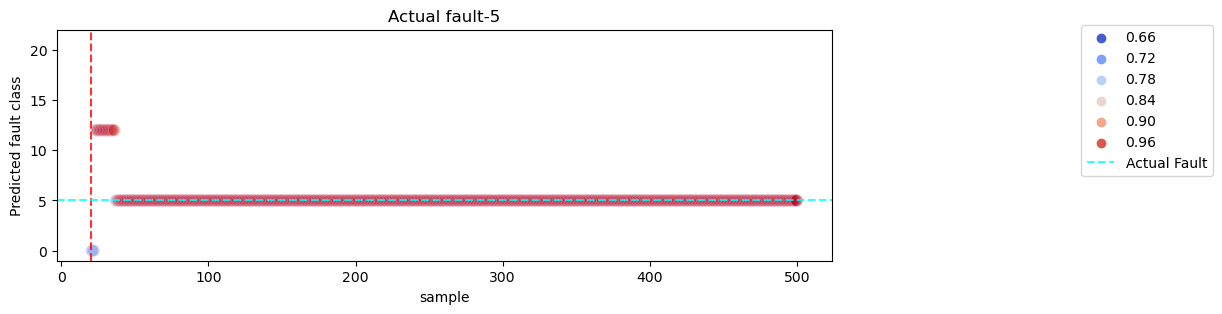

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


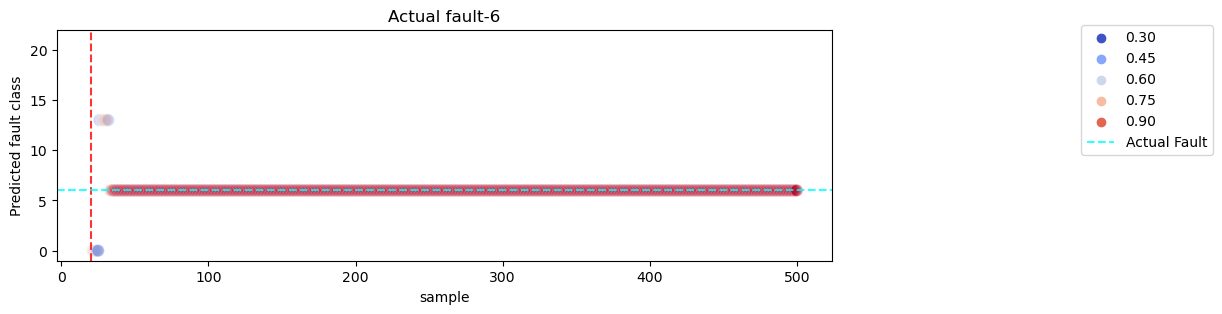

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


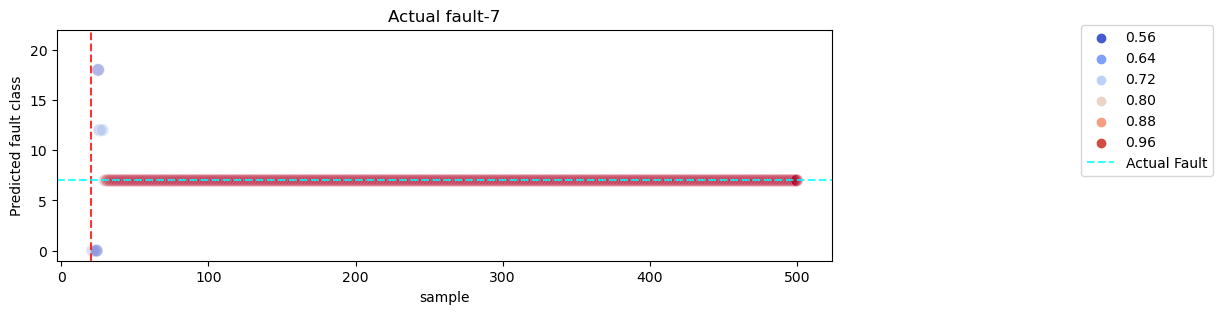

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


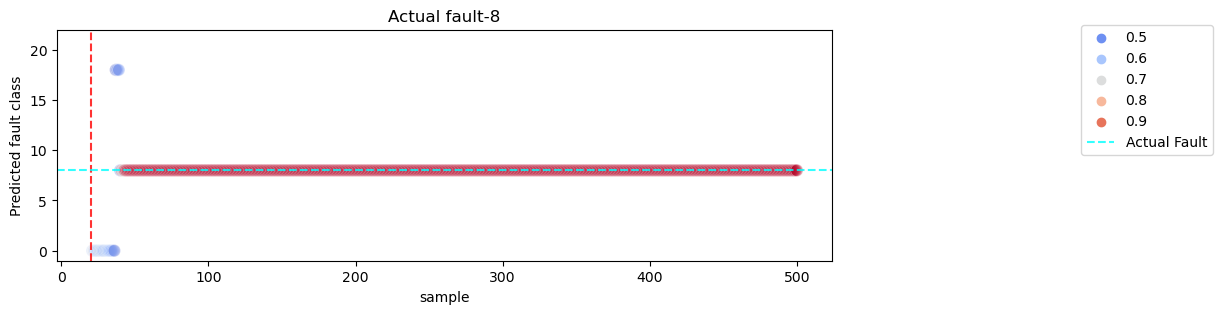

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


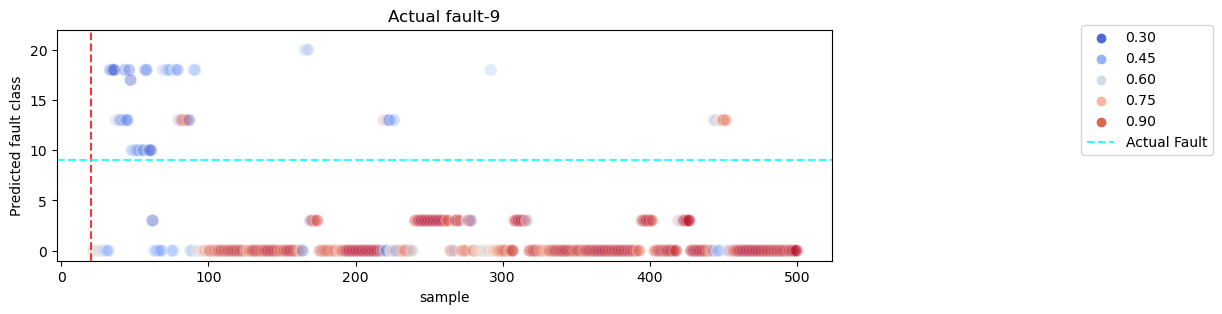

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


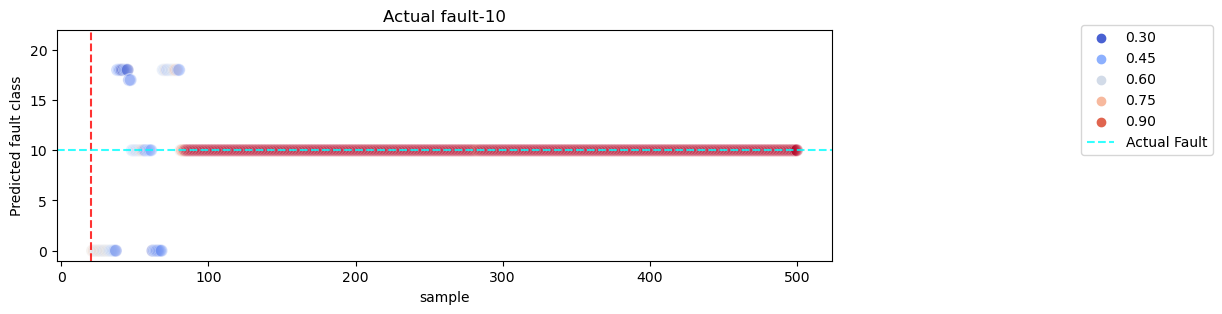

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


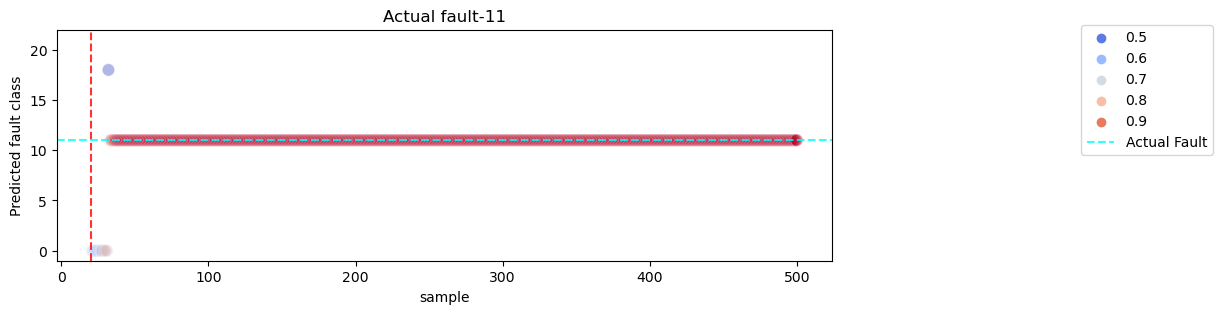

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


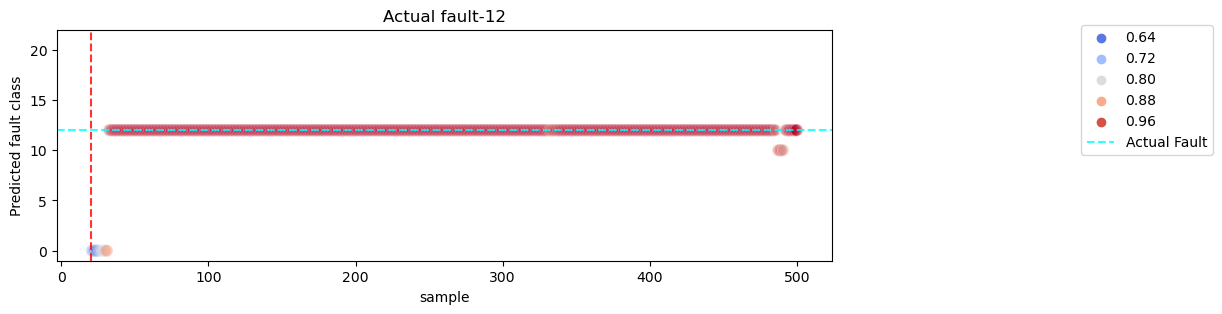

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


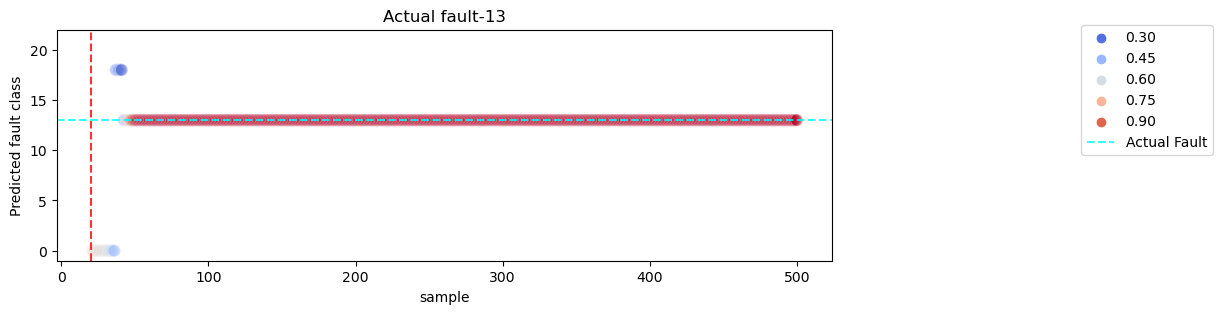

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


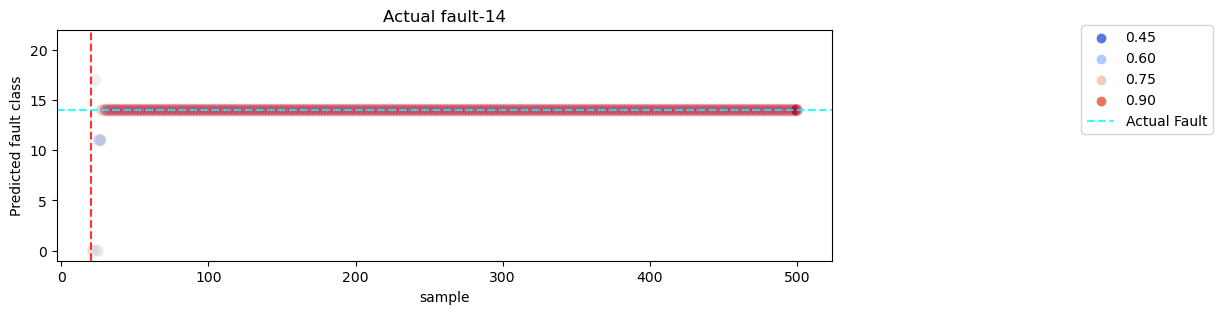

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


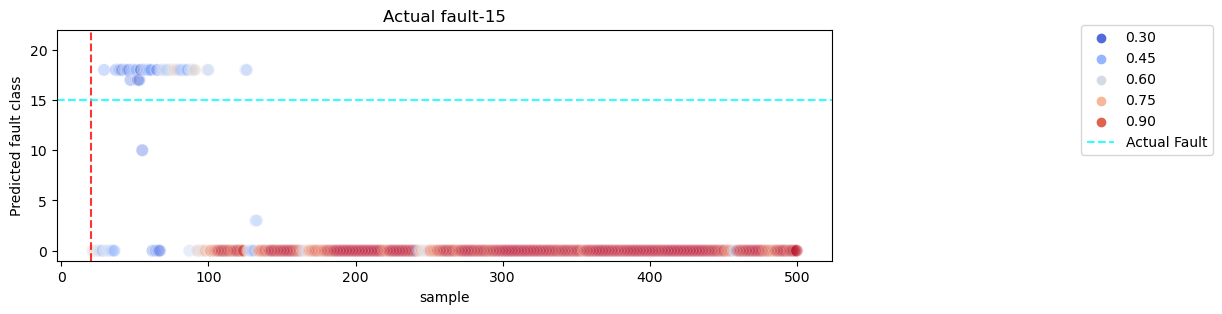

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


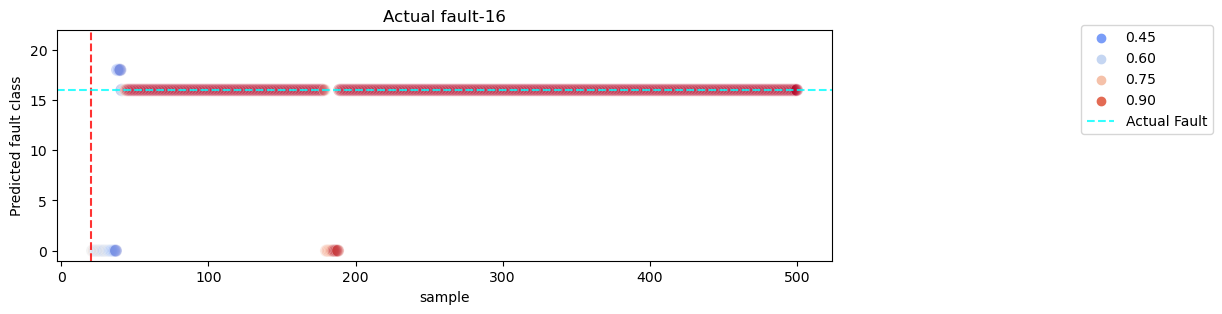

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


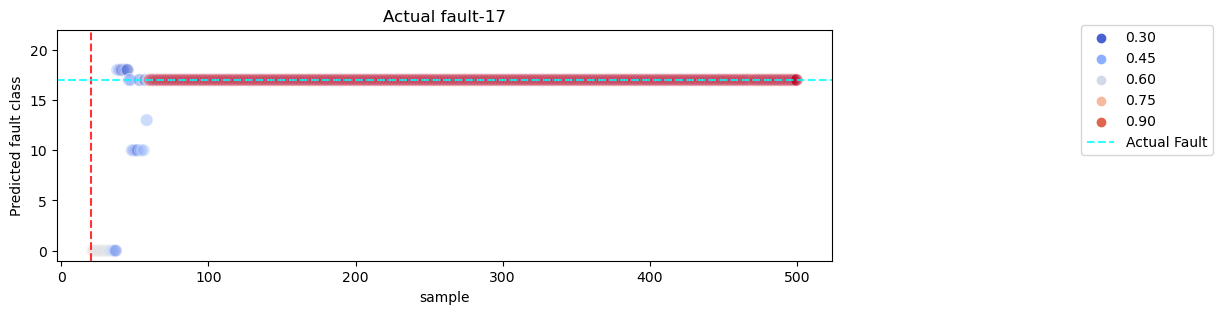

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


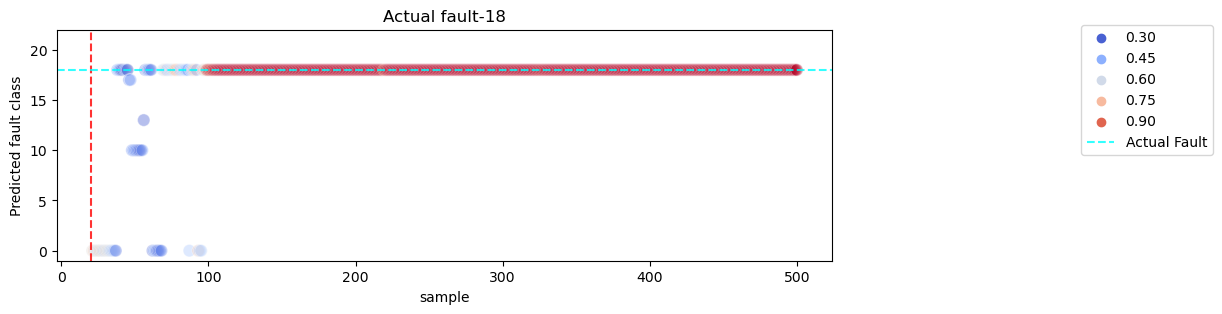

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


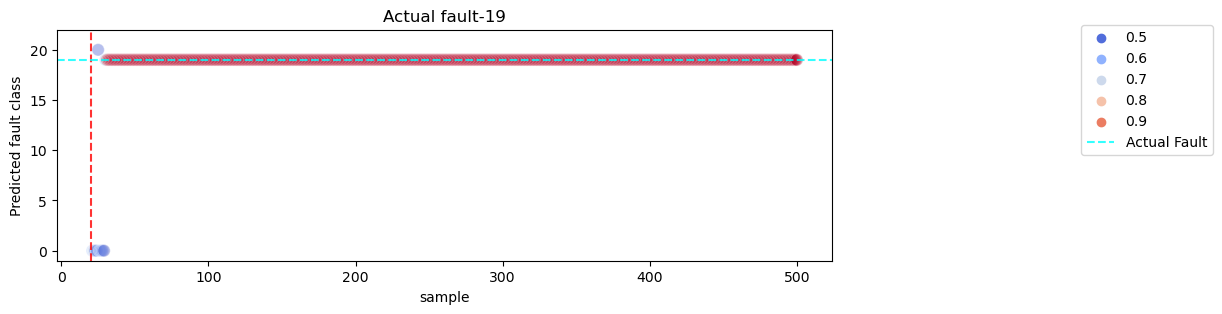

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\622813391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


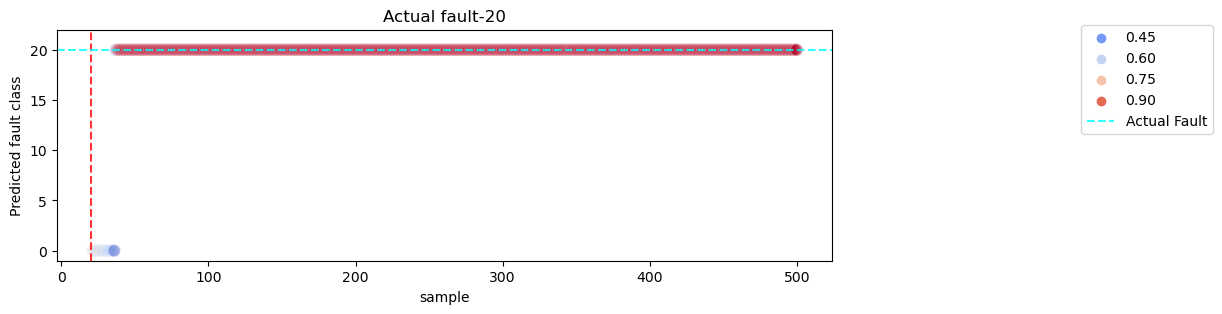

In [24]:
for F_num in range(0,21):
    # select the fault data each fault
    df_new= DF[(DF['faultNumber']==F_num) & (DF['simulationRun']==1)]
    # normalize the data
    df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])

    # create sliding window data
    x_new,y_new =  SlidingWindow(df_new,w=20,s=1)

    # predict fault class and probability for each sliding window
    y_pred = enc.inverse_transform(model.predict(x_new,verbose=0))
    y_proba = np.max(model.predict(x_new, verbose=0),axis=1)

    # plot the results
    f, ax = plt.subplots(figsize=(10,3))
    sns.scatterplot(x=df_new['sample'][w:],y=y_pred[:,0],hue=y_proba,palette="coolwarm",s=80,alpha=0.4,vmin=0, vmax=1)
    plt.axvline(20,c='r',alpha=0.8,linestyle ='--')
    plt.axhline(F_num,c='cyan',alpha=0.8,label='Actual Fault',linestyle ='--')
    plt.legend(bbox_to_anchor=(1.5, 1.05))
    plt.ylabel('Predicted fault class')
    plt.ylim([-1,22])
    plt.title(f'Actual fault-{F_num}')
    plt.show()

# Obtain SIngle Accuracy matrice

In [25]:
#This code calculates the accuracy of the LSTM model for each fault number in the dataset.
Accuracy=[]
#For each fault number in the dataset
for Fnum in [x for x in range(0,21) if x not in [3,9,15]]:
    # Get data for a random simulation run
    df_new= DF[(DF['faultNumber']==F_num) & (DF['simulationRun']==np.random.randint(1,500))]
    # Preprocess data using StandardScaler
    df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])
    
    # Generate sliding windows from data
    x_new,y_true =  SlidingWindow(df_new,w=w,s=1)
    # Predict fault using LSTM model
    y_pred = enc.inverse_transform(model.predict(x_new, verbose=0))
    # Calculate accuracy of predicted fault
    acc = accuracy_score(y_true, y_pred)
    print(f'The accuracy for Fault_num={Fnum} is {acc}')
    # Append accuracy to list
    Accuracy.append(acc)
    
print("#"*20)
print(f'The overall accuracy is {np.mean(Accuracy)}')

C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=0 is 0.85625


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=1 is 0.9604166666666667


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=2 is 0.8729166666666667


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=4 is 0.9645833333333333


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=5 is 0.9479166666666666


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=6 is 0.91875


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=7 is 0.9541666666666667


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=8 is 0.91875


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=10 is 0.9770833333333333


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=11 is 0.9729166666666667


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=12 is 0.925


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=13 is 0.9541666666666667


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=14 is 0.8833333333333333


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=16 is 0.8541666666666666


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=17 is 0.9729166666666667


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=18 is 0.875


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=19 is 0.9229166666666667


C:\Users\Asus\AppData\Local\Temp\ipykernel_11136\2435875088.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.iloc[:,3:] = sc.transform(df_new.iloc[:,3:])


The accuracy for Fault_num=20 is 0.9041666666666667
####################
The overall accuracy is 0.9241898148148149


# t-sne Visualization

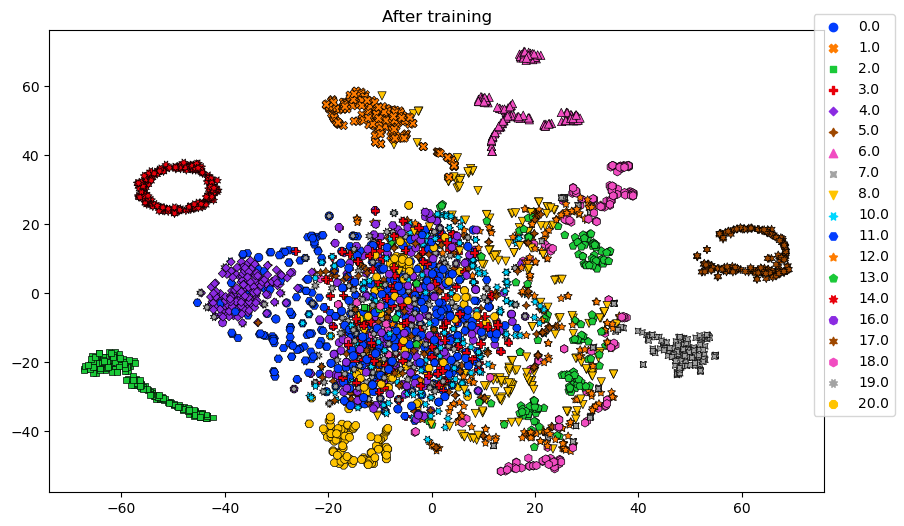

In [26]:
# Reduce the dimensionality of the training data using t-SNE
x_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(x_train[::10,:].reshape(len(x_train[::10,:]),-1))
# Retrieve the original labels for the reduced data
y_label = enc.inverse_transform(y_train[::10,:]).reshape(-1)
# Create a scatterplot of the reduced data with different colors for each class
f, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=x_embedded[:,0],y=x_embedded[:,1],hue=y_label,style=y_label,palette="bright",edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('After training')
plt.show()

# After Training LSTM (t-SNE Visualization)

In [27]:
#Define intermediate model to get the output of the second to last layer
intermediate_model = Model(inputs=model.input,outputs=model.layers[-2].output)
intermediate_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 52)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          185344    
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 300)               38700     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
Total params: 421,164
Trainable params: 421,164
Non-trainable params: 0
_____________________________________________________

108/108 [==============================] - 1s 12ms/step


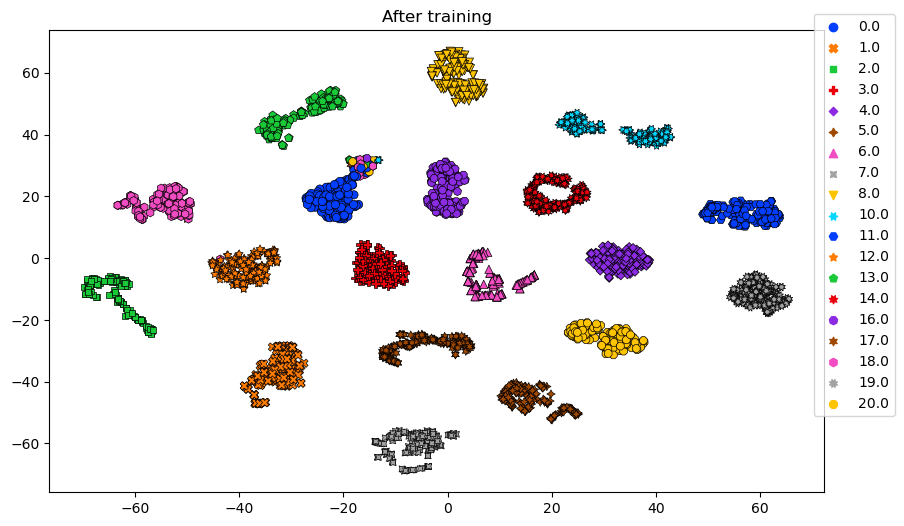

In [31]:
#Get the intermediate output for every 10th data point in the training set
x_inter = intermediate_model.predict(x_train[::10,:])
# Use t-SNE to reduce the dimensionality of the intermediate output to 2D
x_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(x_inter)
# Get the true labels for every data point in the training set
y_label = enc.inverse_transform(y_train[::10,:]).reshape(-1)
# Create a scatter plot of the embedded data, colored by the true labels
f, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=x_embedded[:,0],y=x_embedded[:,1],hue=y_label,style=y_label,palette="bright",edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('After training')
plt.show()